In [84]:
import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from collections import defaultdict
from datetime import date
from os.path import join

%matplotlib inline

data_dir = 'data'
plot_dir = 'figures'

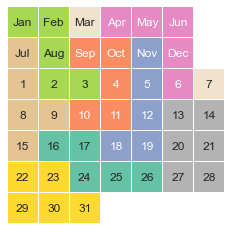

In [94]:
class DatePuzzle:
    """Date puzzle class."""

    def __init__(self):
        """Initialize puzzle."""
        self.reset()

        
    def reset(self):
        """Set empty puzzle board."""
        self.board = np.zeros((7, 7), dtype=int)
        self.board[:2, -1] = -1
        self.board[-1, 3:] = -1
        self.placement_order = []
   

    @property
    def names(self):
        """Names of cells on puzzle board."""
        names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', '', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']
        names += list(range(1, 32)) + [''] * 4
        return names

    
    @property
    def pieces(self):
        """Returns all configurations of eight unique pieces."""
        pieces = set()
        unique_pieces = [
            ((0, 1, 0, 0), (1, 1, 1, 1)),
            ((1, 1, 0), (1, 1, 1)),
            ((0, 1, 1, 1), (1, 1, 0, 0)),
            ((0, 0, 1), (1, 1, 1), (1, 0, 0)),
            ((1, 1, 1, 1), (1, 0, 0, 0)),
            ((1, 1, 1), (1, 0, 1)),
            ((1, 1, 1), (1, 1, 1)),
            ((1, 1, 1), (1, 0, 0), (1, 0, 0))
        ]
        for conf in unique_pieces:
            piece = set()
            axis = 0
            while conf not in piece:
                while conf not in piece:
                    piece.add(conf)
                    conf = tuple(tuple(x) for x in np.rot90(conf))
                conf = tuple(tuple(x) for x in np.flip(conf, axis=axis))
                axis = 1 - axis
            pieces.add(frozenset(piece))
        return pieces
    
    
    @property
    def placed_pieces(self):
        """Pieces that have been placed on the puzzle board."""
        return set(self.placement_order)        
        
        
    @property
    def remaining_pieces(self):
        """Pieces that have not been placed on the puzzle board."""
        return set(self.pieces) - self.placed_pieces
    
    
    @property
    def palette(self):
        """Color palette for puzzle pieces."""
        return dict(zip(self.pieces, sns.color_palette('Set2', len(self.pieces))))
    
    
    def get_piece(self, conf):
        """Get piece from configuration."""
        for piece in self.pieces:
            if conf in piece:
                return piece
                break
        return None
    
    
    def check_placed_piece(self, conf):
        """Check if piece has already been placed on the puzzle board."""
        for piece in self.placed_pieces:
            if conf in piece:
                return True
        return False
    
    
    def check_possible_placement(self, conf, i, j):
        """Check if piece placement is possible on the puzzle board."""
        ix = self.get_board_indices(conf, i, j)
        conf = np.array(conf)
        sb = self.board[ix]
        if conf.shape != sb.shape or (conf & (np.abs(sb) != 0)).any():
            return False
        return True
    
    
    def get_board_indices(self, conf, i, j):
        """Returns indices of puzzle board affected by placing piece configuration."""
        di, dj = np.array(conf).shape
        return np.s_[i:i + di, j:j + dj]
    
    
    def place_piece(self, conf, i, j):
        """Try to place a piece configuration on the puzzle board."""
        
        # Check if piece is a configuration of a valid piece
        piece = self.get_piece(conf)
        if piece is None:
            raise ValueError('Invalid piece.')
            
        # Check if piece has already been placed
        placed = self.check_placed_piece(conf)
        if placed:
            raise ValueError('Piece has already been placed.')
        
        # Add piece configuration to placement order
        self.placement_order.append(piece)
        
        # Check if piece placement is possible
        possible = self.check_possible_placement(conf, i, j)
        if not possible:
            raise ValueError('Impossible piece placement.')

        # Get board indices and place piece
        ix = self.get_board_indices(conf, i, j)
        self.board[ix] = np.array(conf) * len(self.placed_pieces) + self.board[ix]
        
        
    def remove_piece(self, conf):
        """Remove a piece from the puzzle board."""
        piece = self.get_piece(conf)
        i = self.placement_order.index(piece)
        self.board[self.board == i + 1] = 0
        self.placement_order.remove(piece)

        
    def possible_placements(self, piece):
        """All possible placements of piece on the puzzle board."""
        placements = set()
        for conf in piece:
            for i, j in np.argwhere(self.board == 0):
                possible = self.check_possible_placement(conf, i, j)
                if possible:
                    placements.add((conf, i, j))
        return placements
    

    def distance(self, n1, n2):
        """Euclidean distance between two named cells on the puzzle board."""
        x1, y1 = np.unravel_index(self.names.index(n1), self.board.shape)
        x2, y2 = np.unravel_index(self.names.index(n2), self.board.shape)
        return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    
    
    def random_attempt(self, draw_board=False):
        """Try to solve puzzle by randomly placing pieces."""
        pieces = list(self.remaining_pieces)
        random.shuffle(pieces)
        for piece in pieces:
            pp = self.possible_placements(piece)
            if pp:
                p = random.choice(list(pp))
                self.place_piece(*p)
                if draw_board:
                    dp.draw_board()

                    
    def solve(self, month, day, find_all=False):
        """Solve the puzzle for a specific month and day."""
        # Initialize Gurobi model
        model = gp.Model()
        model.setParam('OutputFlag', False)

        # Get names of cells on puzzle board
        names = [x for x in self.names if x]

        # Build matrix of possible placements
        pp = list(set().union(*[self.possible_placements(piece) for piece in self.pieces]))
        cols = []
        for p in pp:
            dp.place_piece(*p)
            col = dp.board.flatten()
            col = col[col >= 0]
            cols.append(col)
            dp.remove_piece(p[0])
        A = np.array(cols).T

        # Build date vector
        b = [int(x not in (month, day)) for x in names]

        # Add vector with one variable for each possible placement
        x = model.addMVar(len(pp), vtype='b')

        # Constrain variables with matrix of possible placements and date vector
        model.addMConstrs(A, x, '=', b)

        # Add constraints preventing the same piece from being placed multiple times
        for piece in dp.pieces:
            cols = [i for i, p in enumerate(pp) if p[0] in piece]
            model.addConstr(x[cols].sum() == 1)
        
        # Solve model
        model.optimize()
        
        # Get piece placements in solution
        pp_sol = [pp[i] for i, v in enumerate(model.getVars()) if v.x == 1]
        
        # Find all remaining solutions
        if find_all:
            pp_sol = [pp_sol]
            while True:
                # Prevent previous solution from being found again
                cols = [i for i, v in enumerate(model.getVars()) if v.x == 1]
                model.addConstr(x[cols].sum() <= len(cols) - 1)
                
                # Solve model
                model.optimize()
                
                if model.status == 2:
                    # Get piece placements in solution
                    pp_sol.append([pp[i] for i, v in enumerate(model.getVars()) if v.x == 1])
                else:
                    # All solutions have been found
                    break

        return pp_sol
    
    
    def draw_board(self):
        """Plot a heatmap of the puzzle board."""
        sns.set(style='ticks', font_scale=1)
        f = plt.figure()
        cmap = ['#f1e2cc'] + [self.palette[piece] for piece in self.placement_order]
        annot = np.reshape(self.names, dp.board.shape).astype(str)
        ax = sns.heatmap(self.board, cbar=False, xticklabels=False, yticklabels=False, square=True,
                         cmap=cmap, linewidths=0.1, mask=self.board < 0, annot=annot, fmt='')

        
# Initialize date puzzle
dp = DatePuzzle()

# Piece configuration
conf = ((0, 0, 1, 1), (1, 1, 1, 0))

# Place piece on the puzzle board
dp.place_piece(conf, 2, 2)

# Check if piece has been placed on board
placed = dp.check_placed_piece(conf)

# Remove piece
dp.remove_piece(conf)

# Check if piece has been placed on board
placed = dp.check_placed_piece(conf)

# Find all possible placements of piece
pp = dp.possible_placements(dp.get_piece(conf))

# Place piece at random position
p = random.choice(list(pp))
dp.place_piece(*p)

# Random attempt at solving the puzzle
dp.random_attempt(draw_board=False)

# Get today's month and day
today = date.today()
month = today.strftime('%b')
day = int(today.strftime('%d'))

# Reset puzzle and solve it for today
dp.reset()
pp = dp.solve(month, day)

# Place pieces and draw board
dp.reset()
for p in pp:
    dp.place_piece(*p)
dp.draw_board()

# # Find all solutions for today
# dp.reset()
# pps = dp.solve(month, day, find_all=True)

# # Place pieces and draw board
# for pp in pps:
#     dp.reset()
#     for p in pp:
#         dp.place_piece(*p)
#     dp.draw_board()

In [66]:
# Find all solutions for all dates
dp = DatePuzzle()
names = [x for x in dp.names if x]
months = names[:12]
days = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
counts = {}
solutions = {}
for i, month in enumerate(months):
    for day in range(1, days[i] + 1):
        pps = dp.solve(month, day, find_all=True)
        dp.reset()
        counts[(month, day)] = len(pps)
        solutions[(month, day)] = pps
        print(month, day, len(pps))

Jan 1 64
Jan 2 109
Jan 3 47
Jan 4 103
Jan 5 83
Jan 6 24
Jan 7 188
Jan 8 79
Jan 9 127
Jan 10 77
Jan 11 74
Jan 12 60
Jan 13 129
Jan 14 88
Jan 15 87
Jan 16 70
Jan 17 133
Jan 18 69
Jan 19 104
Jan 20 195
Jan 21 104
Jan 22 78
Jan 23 188
Jan 24 48
Jan 25 216
Jan 26 84
Jan 27 85
Jan 28 145
Jan 29 74
Jan 30 119
Jan 31 170
Feb 1 73
Feb 2 45
Feb 3 22
Feb 4 41
Feb 5 49
Feb 6 27
Feb 7 88
Feb 8 48
Feb 9 32
Feb 10 47
Feb 11 26
Feb 12 31
Feb 13 59
Feb 14 31
Feb 15 28
Feb 16 26
Feb 17 55
Feb 18 35
Feb 19 45
Feb 20 67
Feb 21 29
Feb 22 25
Feb 23 81
Feb 24 21
Feb 25 78
Feb 26 63
Feb 27 47
Feb 28 81
Feb 29 64
Mar 1 17
Mar 2 24
Mar 3 39
Mar 4 57
Mar 5 32
Mar 6 16
Mar 7 86
Mar 8 66
Mar 9 71
Mar 10 27
Mar 11 40
Mar 12 40
Mar 13 53
Mar 14 44
Mar 15 39
Mar 16 30
Mar 17 60
Mar 18 22
Mar 19 52
Mar 20 61
Mar 21 29
Mar 22 29
Mar 23 92
Mar 24 24
Mar 25 61
Mar 26 72
Mar 27 49
Mar 28 80
Mar 29 49
Mar 30 18
Mar 31 107
Apr 1 55
Apr 2 49
Apr 3 78
Apr 4 56
Apr 5 63
Apr 6 8
Apr 7 104
Apr 8 111
Apr 9 52
Apr 10 88
Apr 11 68


In [68]:
# Get count data
cnt_df = pd.DataFrame([(month, day, count) for (month, day), count in counts.items()], columns=['month', 'day', 'solutions'])
cnt_df

month  day  solutions
0     Jan    1         64
1     Jan    2        109
2     Jan    3         47
3     Jan    4        103
4     Jan    5         83
..    ...  ...        ...
361   Dec   27         71
362   Dec   28        164
363   Dec   29         54
364   Dec   30         60
365   Dec   31         77

[366 rows x 3 columns]

In [69]:
# Add distances between cells to count data
names = [x for x in dp.names if x]
months = dp.names[:12]
days = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
cnt_df['distance'] = [dp.distance(month, day) for i, month in enumerate(months) for day in range(1, days[i] + 1)]
cnt_df

month  day  solutions  distance
0     Jan    1         64  2.000000
1     Jan    2        109  2.236068
2     Jan    3         47  2.828427
3     Jan    4        103  3.605551
4     Jan    5         83  4.472136
..    ...  ...        ...       ...
361   Dec   27         71  4.123106
362   Dec   28        164  4.472136
363   Dec   29         54  6.403124
364   Dec   30         60  5.830952
365   Dec   31         77  5.385165

[366 rows x 4 columns]

In [85]:
# Save count data
cnt_df.to_csv(join(data_dir, 'solution_counts.csv'))

In [87]:
# Save all solutions
for (month, day), pps in solutions.items():
    with open(join(data_dir, '_'.join([month, str(day), 'solutions.csv'])), 'w') as f:
        for pp in pps:
            f.write(str(pp) + '\n')

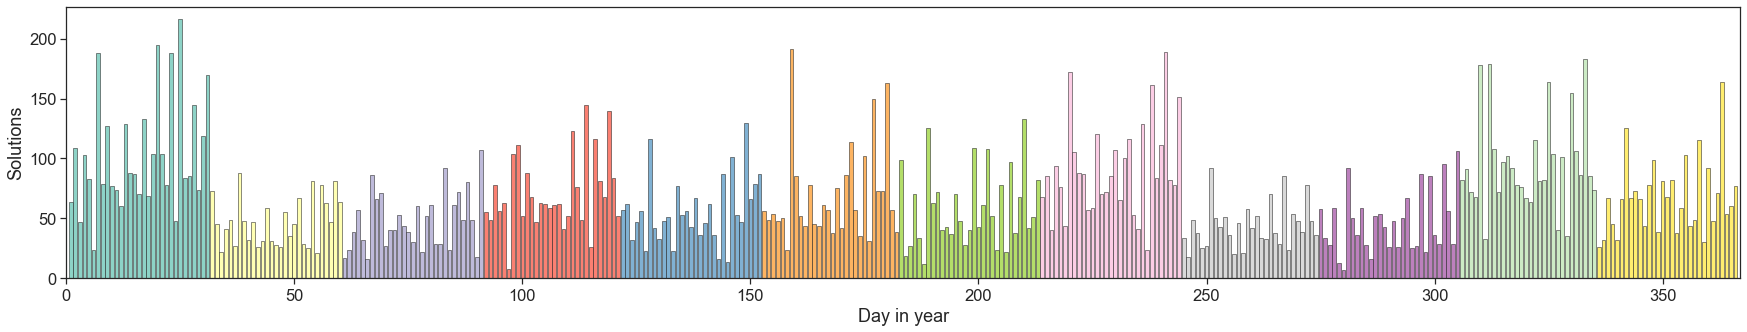

In [692]:
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

df = cnt_df
p = dict(zip(months, sns.color_palette('Set3', len(months))))

plt.bar(x=df.index + 1, height=df.solutions, color=[p[x] for x in df.month], ec='k', lw=0.5)
plt.xlabel('Day in year')
plt.ylabel('Solutions')
plt.xlim(0, len(df) + 1)

f.set_size_inches(30, 5)
f.savefig(join(plot_dir, 'solutions_day_year.pdf'), bbox_inches='tight')

In [734]:
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

df = cnt_df
p = dict(zip(months, sns.color_palette('Set3', len(months))))

ax = sns.barplot(x=df.month, y=df.solutions, palette=p)
plt.xlabel('Month')
plt.ylabel('Solutions')

f.set_size_inches(10, 5)
f.savefig(join(plot_dir, 'solutions_month.pdf'), bbox_inches='tight')

In [677]:
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

df = cnt_df
means = {day: round(row.solutions.mean()) for day, row in df.groupby('day')}

p = dict(zip(sorted(set(means.values())), sns.color_palette('Blues', len(means))))

ax = sns.barplot(x=df.day, y=df.solutions, palette=[p[round(means[x])] for x in df.day])
plt.xlabel('Day in month')
plt.ylabel('Solutions')

f.set_size_inches(30, 5)
f.savefig(join(plot_dir, 'solutions_day_month.pdf'), bbox_inches='tight')

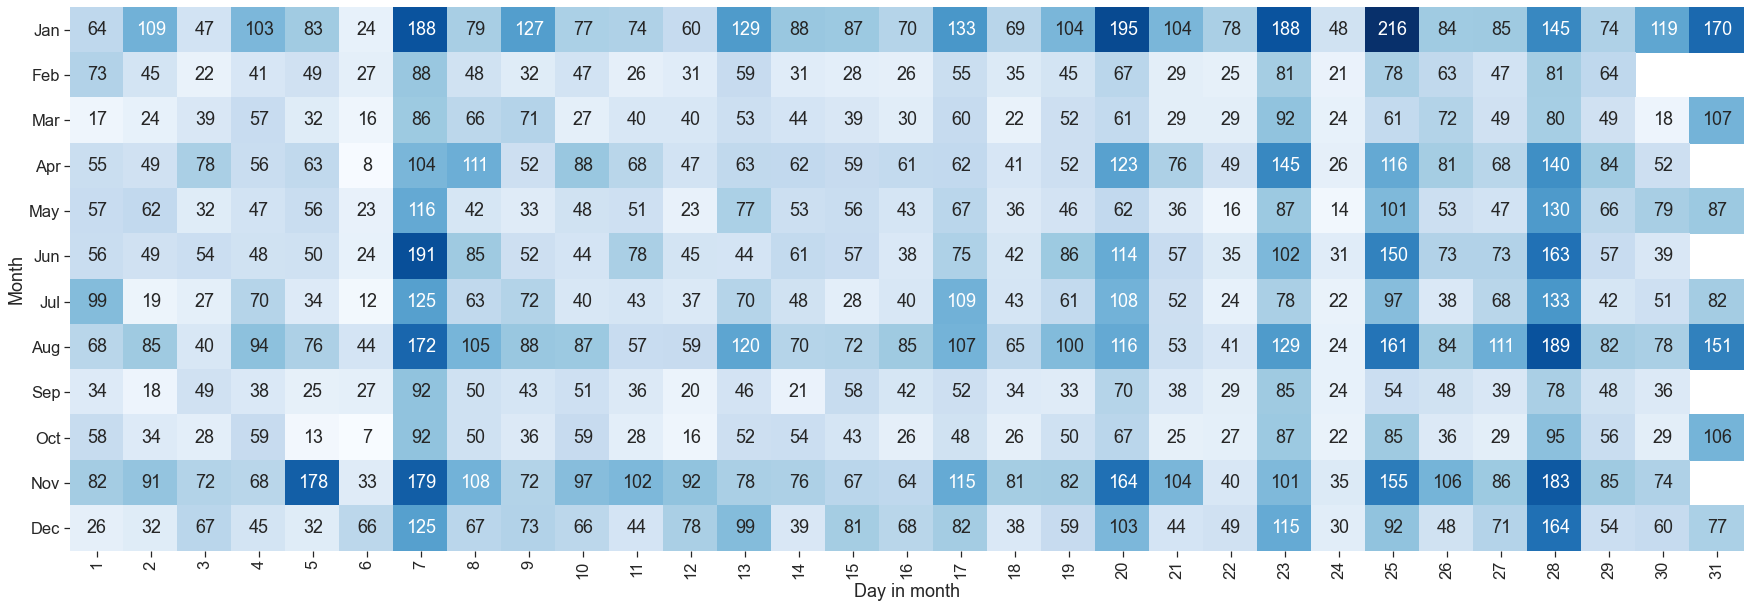

In [678]:
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

df = cnt_df.pivot(index='month', columns='day', values='solutions')

ax = sns.heatmap(df.loc[months], cmap='Blues', xticklabels=1, annot=True, fmt='.0f', cbar=False)
plt.xlabel('Day in month')
plt.ylabel('Month')

f.set_size_inches(30, 10)
f.savefig(join(plot_dir, 'solutions_day_month_all.pdf'), bbox_inches='tight')

In [91]:
d = {}
for x in dp.names:
    for month, df in cnt_df.groupby('month'):
        d[month] = df.solutions.sum()
    for day, df in cnt_df.groupby('day'):
        d[day] = df.solutions.sum()
d[''] = -1
d

{'Apr': 2139,
 'Aug': 2813,
 'Dec': 2094,
 'Feb': 1364,
 'Jan': 3221,
 'Jul': 1835,
 'Jun': 2073,
 'Mar': 1486,
 'May': 1746,
 'Nov': 2870,
 'Oct': 1443,
 'Sep': 1318,
 1: 689,
 2: 617,
 3: 555,
 4: 726,
 5: 691,
 6: 311,
 7: 1558,
 8: 874,
 9: 751,
 10: 731,
 11: 647,
 12: 548,
 13: 890,
 14: 647,
 15: 675,
 16: 593,
 17: 965,
 18: 532,
 19: 770,
 20: 1250,
 21: 647,
 22: 442,
 23: 1290,
 24: 321,
 25: 1366,
 26: 786,
 27: 773,
 28: 1581,
 29: 761,
 30: 635,
 31: 780,
 '': -1}

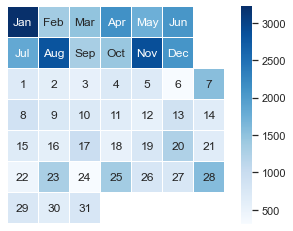

In [104]:
sns.set(style='ticks', font_scale=1)
f = plt.figure()

a = np.array([d[x] for x in dp.names]).reshape(dp.board.shape)
annot = np.reshape(dp.names, dp.board.shape).astype(str)

ax = sns.heatmap(a, cbar=True, xticklabels=False, yticklabels=False, square=True,
                 cmap='Blues', linewidths=0.1, mask=a < 0, annot=annot, fmt='')

f.savefig(join(plot_dir, 'solutions_board.svg'), bbox_inches='tight')

In [731]:
# Ten dates with most solutions
cnt_df.sort_values(by='solutions', ascending=False)[:10]

month  day  solutions
24    Jan   25        216
19    Jan   20        195
158   Jun    7        191
240   Aug   28        189
6     Jan    7        188
22    Jan   23        188
332   Nov   28        183
311   Nov    7        179
309   Nov    5        178
219   Aug    7        172

In [729]:
# Ten dates with fewest solutions
cnt_df.sort_values(by='solutions')[:10]

month  day  solutions
279   Oct    6          7
96    Apr    6          8
187   Jul    6         12
278   Oct    5         13
144   May   24         14
285   Oct   12         16
142   May   22         16
65    Mar    6         16
60    Mar    1         17
89    Mar   30         18

In [103]:
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

df = cnt_df
ax = sns.regplot(df.distance, df.solutions)

plt.xlabel('Euclidean distance')
plt.ylabel('Solutions')
plt.xlim(0.5, 9)

f.savefig(join(plot_dir, 'solutions_distance.pdf'), bbox_inches='tight')

c:\users\ovoy\envs\base\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
